In [152]:
import os
import dotenv
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pltgr



dotenv.load_dotenv()
path_csv = os.getenv("CSV_CHILETRABAJOS")
path_csv2 = os.getenv("CSV_COMPUTRABAJO")

try:
    df= pd.read_csv(path_csv,sep=";",encoding="utf-8")
    print("datos de 'chiletrabajos.com' cargados")
    display(df.head())
except Exception as e:
        print(f"error :{e}")
        
try:
    df2= pd.read_csv(path_csv2,sep=",",encoding="utf-8")
    print("datos 'computrabajo.com' cargados")
    display(df2.head())
except Exception as e:
        print(f"error :{e}")


datos de 'chiletrabajos.com' cargados


,Oferta,Salario,Beneficios,Empresa,Descripcion,Ubicacion,Fecha_Publicacion,Fecha_Expiracion
0,INGENIERO DE SOFTWARE – BLAZOR WEBASSEMBLY .NE...,a convenir,-La empresa paga o copaga una cobertura de sal...,Grupo-O2,En GRUPO O2 busca Ingeniero de Software – Blaz...,Santiago,2025-03-24 10:24:32,2025-06-07 (en 75 días)
1,INGENIERO DE SOFTWARE – FRONTEND REACT Y BACKE...,a convenir,-La empresa paga o copaga una cobertura de sal...,GRUPO-o2,En GRUPO O2 busca Ingeniero de Software – Fron...,Santiago,2025-03-24 10:28:38,2025-06-07 (en 75 días)
2,AYUDANTE CONDUCTOR,NaN,-¡La salud es lo más importante! La empresa pa...,Reclutamiento XR3,En XR3 nos encontramos buscando a nuestro prox...,Illapel,2025-03-22 12:02:01,2025-06-05 (en 73 días)
3,DISEÑADOR UX UI (REMOTO),NaN,-La empresa paga o copaga una cobertura de sal...,Kibernum,¡Únete a nuestro equipo como Diseñador UX UI p...,Santiago,2025-03-21 11:42:15,2025-06-04 (en 72 días)
4,INGENIERO CLOUD OPS,Negociable,-La empresa paga o copaga una cobertura de sal...,Kabeli Selección,Kabeli se encuentra en búsqueda de un Ingenier...,Santiago,2025-03-21 16:03:14,2025-06-04 (en 72 días)


datos 'computrabajo.com' cargados


,Salario,Empresa,Comuna,Región,Cargo
0,NaN,Page Personnel,Santiago - Providencia,R.Metropolitana,Desarrollador Fullstack Controller - Java Spri...
1,NaN,MM ASESORIAS,Santiago Centro,R.Metropolitana,Desarrollador Web
2,2000000.0,Page Personnel,Santiago Centro,R.Metropolitana,Especialista Desarrollador - Proyecto
3,1700000.0,Perceptual Consultores Ltda.,Santiago Centro,R.Metropolitana,Programador Mobile - Android/Java
4,NaN,MM ASESORIAS,Santiago Centro,R.Metropolitana,Desarrollador .NET Senior


In [153]:
tabla_ciudades_ct = df['Ubicacion'].value_counts().reset_index()
tabla_ciudades_ct.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_comput = df2['Comuna'].value_counts().reset_index()
tabla_ciudades_comput.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
print("Cantidades de Ofertas por ciudad\n")
# Concatenamos ambas tablas de ciudades
tabla_ciudades_total = pd.concat([tabla_ciudades_ct, tabla_ciudades_comput])

# Agrupamos por ciudad y sumamos la cantidad de ofertas
tabla_ciudades_total = tabla_ciudades_total.groupby('Ciudad/Comuna', as_index=False).sum()

# Ordenamos por cantidad de ofertas de mayor a menor
tabla_ciudades_total = tabla_ciudades_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla
print("Total de ofertas por ciudad\n")
print(print(tabla_ciudades_total.to_string(index=False)))



Cantidades de Ofertas por ciudad

Total de ofertas por ciudad

          Ciudad/Comuna  Cantidad_Ofertas
               Santiago              1017
             Concepción                49
             Valparaíso                37
            Antofagasta                32
        Santiago Centro                30
               Rancagua                16
           Puerto Montt                13
                Iquique                12
  Santiago - Las condes                11
                Copiapó                10
    Santiago - Vitacura                10
 Santiago - Providencia                10
                 Temuco                 9
              La Serena                 9
                 Calama                 8
            Los Ángeles                 7
                  Talca                 7
               Valdivia                 6
Santiago - Lo Barnechea                 6
                Illapel                 6
                Chillán                 6
             

In [154]:
def clasificar_puesto(oferta):
    oferta = str(oferta).lower()
    if 'frontend' in oferta:
        return 'Frontend'
    elif 'analista' in oferta:
        return 'Analista'
    elif 'backend' in oferta:
        return 'Backend'
    elif 'fullstack' in oferta:
        return 'Fullstack'
    elif 'devops' in oferta:
        return 'DevOps'
    elif 'qa' in oferta or 'tester' in oferta:
        return 'QA'
    elif 'data' in oferta or 'analista' in oferta:
        return 'Data'
    elif 'mobile' in oferta or 'android' in oferta or 'ios' in oferta:
        return 'Mobile'
    elif 'ux' in oferta:
        return 'UX'
    elif 'desarrollador' or 'developer' or 'programador' or 'ingeniero de software' in oferta:
        return 'Developer'
    else:
        return 'Otros'
df['Puesto'] = df['Oferta'].apply(clasificar_puesto)
df2['Puesto'] = df2['Cargo'].apply(clasificar_puesto)
tabla_puestos_comput = df2['Puesto'].value_counts().reset_index()
tabla_puestos = df['Puesto'].value_counts().reset_index()
tabla_puestos.columns = ['Puesto', 'Cantidad_Ofertas']
tabla_puestos_comput.columns = ['Puesto', 'Cantidad_Ofertas']


In [155]:
# Concatenamos ambas tablas
tabla_total = pd.concat([tabla_puestos, tabla_puestos_comput])

# Agrupamos por 'Puesto' y sumamos las ofertas
tabla_total = tabla_total.groupby('Puesto', as_index=False).sum()

# Ordenamos de mayor a menor cantidad de ofertas
tabla_total = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla final
print("Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)\n")
print(tabla_total.to_string(index=False))

Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)

   Puesto  Cantidad_Ofertas
Developer              1536
 Analista               114
   Mobile                92
Fullstack                43
 Frontend                32
  Backend                27
     Data                27
   DevOps                14
       UX                11
       QA                10


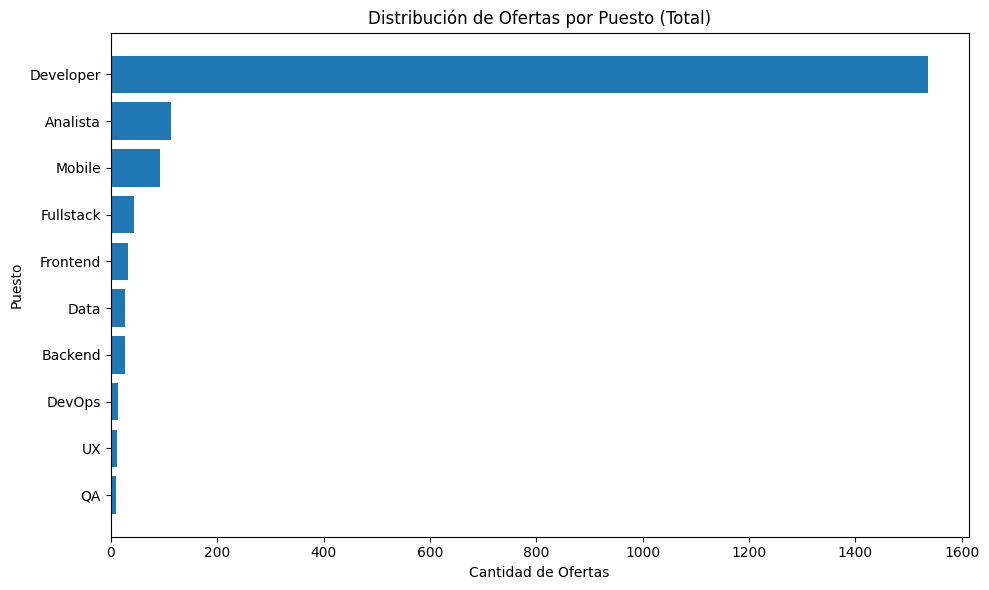

In [ ]:
# Pie chart de puestos
tabla_total_sorted = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=True)

pltgr.figure(figsize=(10, 6))
pltgr.barh(tabla_total_sorted['Puesto'], tabla_total_sorted['Cantidad_Ofertas'])
pltgr.xlabel('Cantidad de Ofertas')
pltgr.ylabel('Puesto')
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()




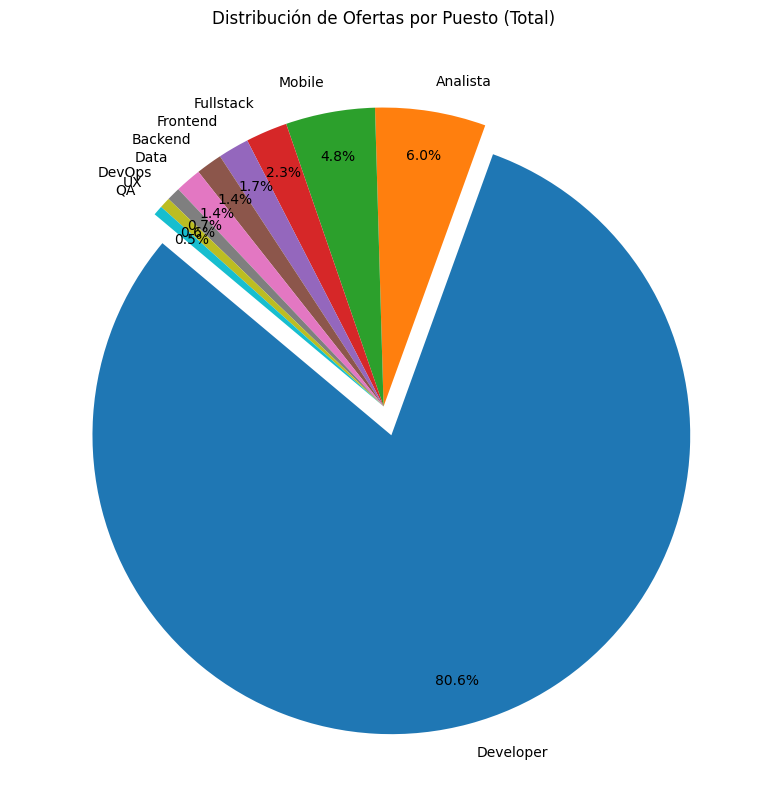

In [160]:

labels = tabla_total['Puesto']
sizes = tabla_total['Cantidad_Ofertas']

# Explode la categoría más grande (opcional)
explode = [0.1 if s == max(sizes) else 0 for s in sizes]

pltgr.figure(figsize=(8, 8))
pltgr.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    pctdistance=0.85,
    labeldistance=1.1
)
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()